# Jupyter intro

### Useful shortcuts:
- Shift + Tab - function tooltip
- Shift + Tab + Tab - more detailed function info
- Tab - autocomplete list
- Shift + Enter - run cell

# Pandas intro

### Load all libraries needed

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn # for prettier plots, probably need to install it => conda install seaborn
%matplotlib inline

c:\python35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load datasets
All datasets are complete, there is no holes in them. Time represents number of hours from 2005-01-01.

In [2]:
# with open('weather.pickle', 'rb') as file:
#     weather = pickle.load(file)
# with open('smog.pickle', 'rb') as file:
#     smog = pickle.load(file)
#     # smog -> dictionary, key is station number as string ex.
#     # smog['6']['data']
with open('weather-unnorm.pickle', 'rb') as file:
    weather = pickle.load(file)
    weather = weather['weather']
with open('smog-unnorm.pickle', 'rb') as file:
    smog = pickle.load(file)
    # smog -> dictionary, key is station number as string ex.
    # smog['6']['data']

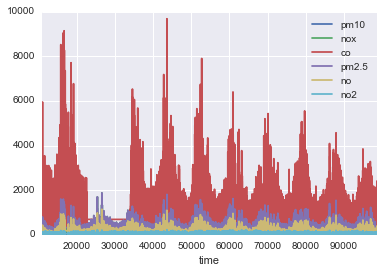

In [3]:
smog['6'].plot(x='time')

#### About normalization
Datasets are also normalized.
To convert data back to original form use:
$$o = d \cdot (o_{max} - o_{min}) + o_{mean}$$
```python
# Ex.
smog_origin = smog[STATION]['data'] * (smog[STATION]['max'] - smog[STATION]['min']) + smog[STATION]['mean']
```

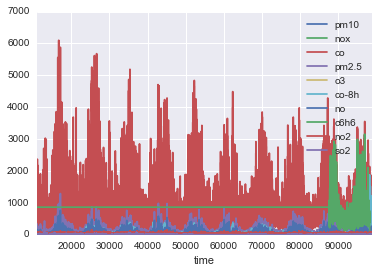

In [4]:
# smog_origin = smog['7']['data'] * (smog['7']['max'] - smog['7']['min']) + smog['7']['mean']
smog['7'].plot(x='time')

### Useful functions for unnormalizing data

In [5]:
def unnormalize(x, min_value, max_value, mean_value):
    return x * (max_value - min_value) + mean_value

In [6]:
def unnormalize_smog(x, station, substance):
    return unnormalize(x, smog[station]['min'][substance], smog[station]['max'][substance], smog[station]['mean'][substance])

In [7]:
def unnormalize_weather(x, what):
    return unnormalize(x, weather['min'][what], weather['max'][what], weather['mean'][what])

### For converting `time` column

In [8]:
def hours_to_date(x):
    base_time = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return pd.to_datetime(base_time // 1000000000 + x * 3600, unit='s')

In [9]:
def date_to_hours(date):
    if type(date) == type(''):
        date = pd.to_datetime(date)
    base_date = pd.to_datetime('2005-01-01').to_datetime64().astype('int64')
    return int((date.to_datetime64().astype('int64') - base_date) // 3600000000000)

# Scikit learn - Regression

In [10]:
from sklearn import linear_model

# Actual work
We will work on `weather_smog` dataset, but first we need to split it on train, validation, test sets. We will always train our model on train set then try to evaluate it on validation set and fine-tune hyper-parameters. At the very end we will check our model on test set.

In [11]:
weather_data = weather.copy()
smog_data = smog['7'].copy()

In [12]:
def create_and_fit_model(X, y):
    model = linear_model.LinearRegression(n_jobs=8, normalize=True)
    model.fit(X, y)
    return model

In [13]:
def plot_fitted_data(model, X, y, begin=0, end=100, station='7', substance='co'):
    prediction = model.predict(X)
    plt.figure(figsize=(16, 9))
    tmp = X[:]
    tmp['target'] = y
    tmp['pred'] = prediction
    tmp = tmp.sort_values(by='time')
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['target'], station, substance)[begin:end])
    plt.plot(tmp['time'][begin:end], unnormalize_smog(tmp['pred'], station, substance)[begin:end])
    plt.show()

In [14]:
def plot_dependency(model, feature_list):
    index = np.arange(len(feature_list))
    bar_width = 0.35
    plt.figure(figsize=(16, 9))
    plt.bar(index, model.coef_, bar_width)
    plt.xticks(index + bar_width / 2, feature_list)
    plt.tight_layout()
    plt.show()

# Model for PM10 only

In [15]:
subst_data = smog_data[['time', 'pm10']]
subst_data.head()

,time,pm10
0,10920,40.0
1,10921,28.0
2,10922,7.0
3,10923,6.0
4,10924,11.0


## Prepare targets for all data

In [16]:
def split_time_column(data):
    dates = data['time'].apply(hours_to_date)
    data['hour'] = dates.apply(lambda x: x.hour)
    data['weekday'] = dates.apply(lambda x: x.dayofweek)
    data['monthday'] = dates.apply(lambda x: x.day)
    data['weekyear'] = dates.apply(lambda x: x.weekofyear)
    data['dayyear'] = dates.apply(lambda x: x.dayofyear)
    data['month'] = dates.apply(lambda x: x.month)
    return data

In [17]:
subst = split_time_column(subst_data)

c:\python35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\python35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python35\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [18]:
# subst = subst.drop('time', 1)

In [19]:
subst.head()

,time,pm10,hour,weekday,monthday,weekyear,dayyear,month
0,10920,40.0,0,5,1,13,91,4
1,10921,28.0,1,5,1,13,91,4
2,10922,7.0,2,5,1,13,91,4
3,10923,6.0,3,5,1,13,91,4
4,10924,11.0,4,5,1,13,91,4


## Add weather features

In [20]:
# weather_data['time'] -= 24
temp_weather = weather_data.copy()
temp_weather['time'] -= 24

In [21]:
print(temp_weather['time'][0])
print(weather['time'][0])

57436
57460


In [22]:
subst_weather = pd.merge(subst, temp_weather, on='time')
subst_weather = subst_weather[subst_weather['time'] >= 57500]

In [23]:
len(subst_weather)

41212

In [24]:
target_subst = 'pm10'
subst_weather['target'] = subst_weather[target_subst].shift(-24, axis=0)

subst_weather = subst_weather[subst_weather['time'] >= 57500][:40000]
subst_weather.head()

,time,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,57500,25.0,20,6,24,29,205,7,230.0,92.13,982.80,1.240,9.93,14.31,48.0
65,57501,30.0,21,6,24,29,205,7,236.0,92.16,983.15,1.220,10.03,14.10,46.0
66,57502,31.0,22,6,24,29,205,7,242.0,91.65,983.44,1.200,10.03,14.07,43.0
67,57503,29.0,23,6,24,29,205,7,261.0,91.40,983.63,0.910,10.03,14.17,42.0
68,57504,41.0,0,0,25,30,206,7,264.0,91.82,983.89,0.965,10.03,14.23,41.0


In [25]:
subst_weather = subst_weather.drop('time', 1)

In [26]:
subst_weather[:72:24]

,pm10,hour,weekday,monthday,weekyear,dayyear,month,wind-direction,humidity,pressure,wind-speed,rain,temperature,target
64,25.0,20,6,24,29,205,7,230.0,92.13,982.80,1.240000,9.93,14.31,48.0
88,48.0,20,0,25,30,206,7,216.0,84.75,987.27,0.583333,0.11,18.44,36.0
112,36.0,20,1,26,30,207,7,274.0,90.71,990.71,0.960000,7.85,16.69,22.0


## Add new features here

In [27]:
# new features
features = list(subst_weather.columns)
features.remove('target')
print(features)

['pm10', 'hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month', 'wind-direction', 'humidity', 'pressure', 'wind-speed', 'rain', 'temperature']


## Split dataset

In [28]:
def split_data(data, size, rnd=42):
    np.random.seed(rnd)
    dataset = data.reindex(np.random.permutation(data.index))
    length = int(len(data) * size)
    return dataset[:length], dataset[length:]

In [29]:
train, valid_test = split_data(subst_weather, 0.6)
valid, test = split_data(valid_test, 0.5)
print("Train size:", len(train))
print("Valid size:", len(valid))
print("Test  size:", len(test))

Train size: 24000
Valid size: 8000
Test  size: 8000


## Model for PM10

In [30]:
def make_model_for_label(data, features, target):
    return create_and_fit_model(np.array(data[features]), np.array(data[target + '-target']))

In [31]:
model = create_and_fit_model(train[features], train['target'])

In [32]:
for feature, coef in zip(features, model.coef_):
    print('%-15s: % 2.5f' % (feature, coef))

pm10           :  0.32052
hour           :  0.28632
weekday        : -0.65757
monthday       : -1.97085
weekyear       : -0.26035
dayyear        :  1.94065
month          : -57.26884
wind-direction : -0.00881
humidity       : -0.30027
pressure       :  0.35040
wind-speed     : -11.11550
rain           : -0.76799
temperature    : -1.79143


## Evaluate model on validation set

In [33]:
print('pm10:', model.score(valid[features], valid['target']))

pm10: 0.394816241015


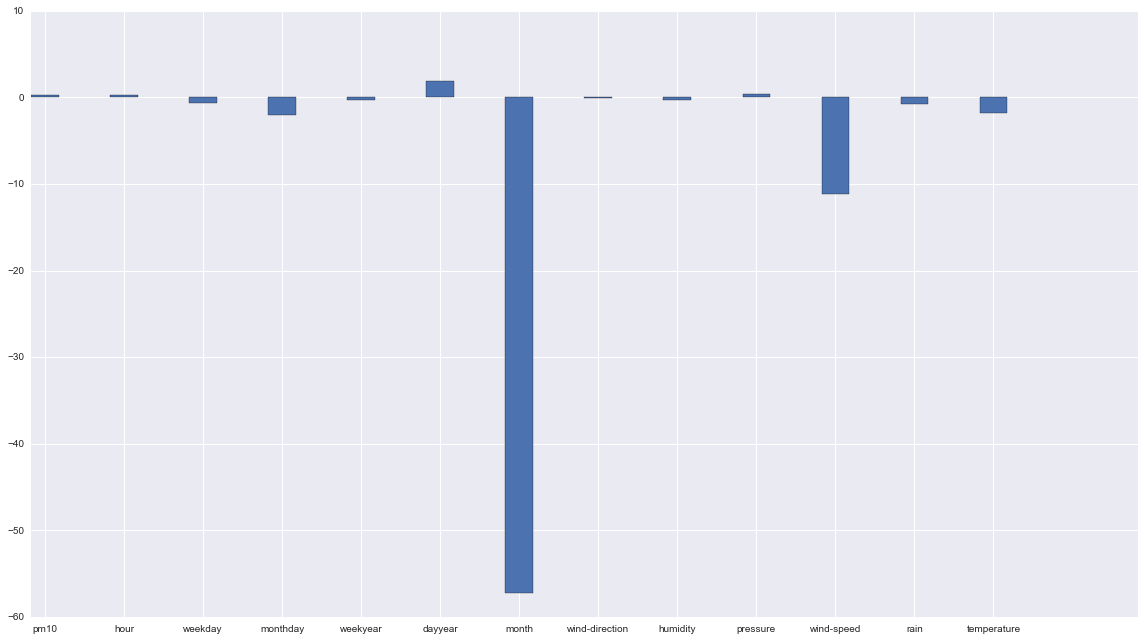

In [34]:
plot_dependency(model, features)

## Check the previous day prediction model

In [35]:
def create_naive_model(data, feature, target):
    return create_and_fit_model(np.array(data[feature]).reshape((-1, 1)), np.array(data[target]))

In [36]:
previous_day_model = create_naive_model(train, 'pm10', 'target')

In [37]:
previous_day_model.coef_

array([ 0.4866892])

In [38]:
print('Score:', previous_day_model.score(np.array(valid['pm10']).reshape((-1, 1)), np.array(valid['target'])))

Score: 0.252910579775


# Create models for all other substances

In [39]:
all_substances = smog_data.copy()
target_features = list(all_substances.columns)
target_features.remove('time')
print(target_features)
all_substances.head()

['pm10', 'nox', 'co', 'pm2.5', 'o3', 'co-8h', 'no', 'c6h6', 'no2', 'so2']


,time,pm10,nox,co,pm2.5,o3,co-8h,no,c6h6,no2,so2
0,10920,40.0,30.0,672.0,30.0,13.0,28.0581,2.0,866.569,28.0,0.2
1,10921,28.0,27.0,672.0,27.0,11.0,28.0581,1.0,866.569,25.0,1.0
2,10922,7.0,15.0,340.0,15.0,11.0,28.0581,1.0,866.569,13.0,0.1
3,10923,6.0,12.0,330.0,12.0,9.0,28.0581,1.0,866.569,11.0,0.0
4,10924,11.0,11.0,330.0,11.0,9.0,28.0581,0.0,866.569,11.0,0.0


In [40]:
all_weather = weather_data.copy()
all_weather['time'] -= 24
print(all_weather['time'][0])
print(weather_data['time'][0])

57436
57460


In [41]:
all_substances = pd.merge(all_substances, all_weather, on='time')

In [42]:
all_substances.head()

,time,pm10,nox,co,pm2.5,o3,co-8h,no,c6h6,no2,so2,wind-direction,humidity,pressure,wind-speed,rain,temperature
0,57436,4.0,13.0,270.0,13.0,6.0,4.0,0.0,866.569,13.0,4.2,178.0,80.15,980.49,0.67,0.0,11.57
1,57437,4.0,21.0,230.0,21.0,7.0,4.0,1.0,866.569,18.0,4.2,269.0,77.46,980.71,0.89,0.0,11.62
2,57438,4.0,31.0,310.0,31.0,7.0,4.0,4.0,866.569,23.0,4.2,235.0,69.73,980.95,0.71,0.0,12.91
3,57439,4.0,31.0,330.0,31.0,6.0,4.0,6.0,866.569,21.0,4.2,155.0,67.52,981.10,0.69,0.0,14.09
4,57440,4.0,42.0,340.0,42.0,4.0,4.0,9.0,866.569,28.0,4.2,242.0,62.31,981.23,3.24,0.0,15.62


In [43]:
for feature in target_features:
    all_substances[feature + '-target'] = all_substances[feature].shift(-24, axis=0)
all_substances[:72:24]

,time,pm10,nox,co,pm2.5,o3,co-8h,no,c6h6,no2,...,pm10-target,nox-target,co-target,pm2.5-target,o3-target,co-8h-target,no-target,c6h6-target,no2-target,so2-target
0,57436,4.0,13.0,270.0,13.0,6.0,4.0,0.0,866.569,13.0,...,11.0,14.0,230.0,14.0,2.0,4.0,0.0,866.569,14.0,4.2
24,57460,11.0,14.0,230.0,14.0,2.0,4.0,0.0,866.569,14.0,...,30.0,12.0,340.0,12.0,2.0,15.0,0.0,866.569,11.0,4.2
48,57484,30.0,12.0,340.0,12.0,2.0,15.0,0.0,866.569,11.0,...,19.0,20.0,280.0,20.0,3.0,10.0,3.0,866.569,16.0,4.2


In [44]:
all_substances = all_substances[all_substances['time'] >= 57500][:40000]
all_substances = split_time_column(all_substances)
all_substances = all_substances.drop('time', 1)

In [45]:
# train, valid_test = split_data(all_substances, 0.6)
train, test = split_data(all_substances, 0.8)
# valid, test = split_data(valid_test, 0.5)
print("Train size:", len(train))
# print("Valid size:", len(valid))
print("Test  size:", len(test))

Train size: 32000
Test  size: 8000


In [46]:
all_features = list(all_substances.columns)
all_features = list(filter(lambda x: not x.endswith('-target'), all_features))
models = {}
naive_models = {}
for feature in target_features:
    models[feature] = create_and_fit_model(train[all_features], train[feature + '-target'])
    naive_models[feature] = create_naive_model(train, feature, feature + '-target')

# Save models

In [47]:
with open('smog-models.pickle', 'wb') as save:
    pickle.dump(models, save)

In [48]:
all_features

['pm10',
 'nox',
 'co',
 'pm2.5',
 'o3',
 'co-8h',
 'no',
 'c6h6',
 'no2',
 'so2',
 'wind-direction',
 'humidity',
 'pressure',
 'wind-speed',
 'rain',
 'temperature',
 'hour',
 'weekday',
 'monthday',
 'weekyear',
 'dayyear',
 'month']

## One substance + weather

In [49]:
general_features = ['wind-direction', 'humidity', 'pressure', 'wind-speed', 'rain', 
                    'temperature', 'hour', 'weekday', 'monthday', 'weekyear', 'dayyear', 'month']
substance_features = list(smog_data.columns)
substance_features.remove('time')
print(substance_features)

['pm10', 'nox', 'co', 'pm2.5', 'o3', 'co-8h', 'no', 'c6h6', 'no2', 'so2']


In [50]:
one_models = {}
for feature in substance_features:
    one_models[feature] = create_and_fit_model(train[[feature] + general_features], train[feature + '-target'])

## Models comparison

In [51]:
for name, model in naive_models.items():
    print('%-6s: %2.10f' % (name, model.score(np.array(test[name]).reshape((-1, 1)), np.array(test[name + '-target']))))

so2   : 0.2885976476
pm10  : 0.2435890449
c6h6  : 0.3194852510
no    : 0.1734275473
o3    : 0.2946715783
pm2.5 : 0.1880625602
nox   : 0.1826814841
co-8h : 0.2830257150
no2   : 0.1964172387
co    : 0.2136975224


In [52]:
for name, model in one_models.items():
    print('%-6s: %2.10f' % (name, model.score(test[[name] + general_features], test[name + '-target'])))

so2   : 0.3669294485
pm10  : 0.3869843284
c6h6  : 0.3414053970
no    : 0.2595337969
o3    : 0.3885241333
pm2.5 : 0.2914025091
nox   : 0.2982541220
co-8h : 0.4274955935
no2   : 0.3152320144
co    : 0.3305248354


In [53]:
for name, model in models.items():
    print('%-6s: %2.10f' % (name, model.score(test[all_features], test[name + '-target'])))

so2   : 0.3723091854
pm10  : 0.3898235553
c6h6  : 0.3529689198
no    : 0.2615894057
o3    : 0.3991043489
pm2.5 : 0.2933320891
nox   : 0.3006744788
co-8h : 0.4308973394
no2   : 0.3202284763
co    : 0.3319571797


In [54]:
# with open('mean-values.pickle', 'wb') as save:
#     pickle.dump(train[all_features].mean().to_dict(), save)

In [55]:
# with open('smog-one-models.pickle', 'wb') as save:
#     pickle.dump(one_models, save)

## Plotting

In [56]:
temp_weather = weather_data.copy()
temp_weather['time'] -= 24
smog_weather = pd.merge(smog_data, temp_weather, on='time')
smog_weather = split_time_column(smog_weather)
smog_weather.head()

,time,pm10,nox,co,pm2.5,o3,co-8h,no,c6h6,no2,...,pressure,wind-speed,rain,temperature,hour,weekday,monthday,weekyear,dayyear,month
0,57436,4.0,13.0,270.0,13.0,6.0,4.0,0.0,866.569,13.0,...,980.49,0.67,0.0,11.57,4,4,22,29,203,7
1,57437,4.0,21.0,230.0,21.0,7.0,4.0,1.0,866.569,18.0,...,980.71,0.89,0.0,11.62,5,4,22,29,203,7
2,57438,4.0,31.0,310.0,31.0,7.0,4.0,4.0,866.569,23.0,...,980.95,0.71,0.0,12.91,6,4,22,29,203,7
3,57439,4.0,31.0,330.0,31.0,6.0,4.0,6.0,866.569,21.0,...,981.10,0.69,0.0,14.09,7,4,22,29,203,7
4,57440,4.0,42.0,340.0,42.0,4.0,4.0,9.0,866.569,28.0,...,981.23,3.24,0.0,15.62,8,4,22,29,203,7


In [59]:
def plot_period(date1, date2, subst):
    hour1 = date_to_hours(date1)
    hour2 = date_to_hours(date2)
    temp = smog_weather[(smog_weather['time'] >= hour1) & (smog_weather['time'] <= hour2)]
    temp2 = smog_weather[(smog_weather['time'] >= hour1 + 24) & (smog_weather['time'] <= hour2 + 24)]
    plt.figure(figsize=(16, 9))
    p1 = plt.plot(temp['time'], one_models[subst].predict(temp[[subst] + general_features]), label='prediction')
    p2 = plt.plot(temp['time'], temp2[subst], label='actual')
    plt.legend()
    plt.show()

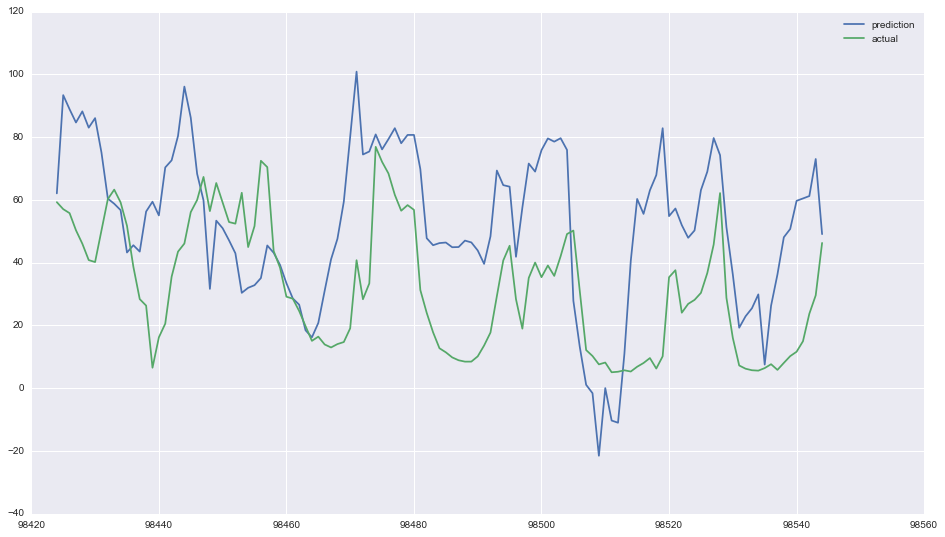

In [60]:
plot_period('2016-03-25', '2016-03-30', 'pm2.5')